# This Program performs Binary Image Classification using fastai libraries
#### This program is written for Python version 3

In [1]:
#To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
%reload_ext autoreload
%autoreload 2

#To inline the output of plotting commands is displayed inline within frontend Jupyter notebook
%matplotlib inline

In [2]:
# Confirm Python Version 3
from platform import python_version
print(python_version())

3.6.7


In [3]:
import os
#Change working Directory to import Fastai libraries
os.chdir('/home/paperspace/fastai/courses/dl1')
%pwd

'/home/paperspace/fastai/courses/dl1'

In [4]:
# Import all main extrnal libraries
from fastai.imports import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
# Manage transformation library written from scratch in PyTorch. 
# The main purpose of the library is for data augmentation, also use it for more general image transformation purposes
from fastai.transforms import *

# Get a pre-trained model with the fast ai library
from fastai.conv_learner import *

# DL models by fastai (http://files.fast.ai/models/)
from fastai.models import *

# Module has the necessary functions to be able to download several useful datasets
from fastai.dataset import *

# Module to reform SGDR
from fastai.sgdr import *

# Module to display plots - such as larning rate
from fastai.plots import *

-  'sz' is size of images, should be changed in order to perform fast training

In [6]:
#Path is path to Data
PATH= '/home/paperspace/fastai/courses/SelfCodes/Binary_Image_Classiff_cats_dogs/Binary_Image_Classiff_cats_dogs/data/dogscats/'
sz=224

In [7]:
# NVidia GPU with programming framework CUDA is critical & following command must return true
torch.cuda.is_available()

True

In [8]:
# Make sure deep learning package from CUDA CuDNN is enabled for improving training performance ( prefered)
torch.backends.cudnn.enabled

True

####  Confirm the product structure of PATH 
-  Path needs to have 'train' and 'valid' folders , both folders subfoders with 'cats' & 'dogs'
-  'tmp' shall store precompute activations
-  for debugging we may delete contents of 'tmp' 
-  'models' folder shall save trained models

In [9]:
# list directories of 'valid'
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [10]:
# list directories of 'PATH'
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [11]:
# Observe file names
os.listdir(f'{PATH}valid/cats')[0]

'cat.11341.jpg'

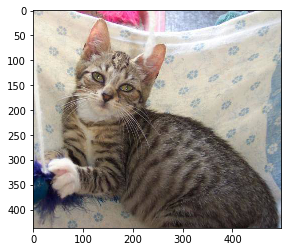

In [12]:
# observe cat picture
img = plt.imread(PATH + 'valid/cats/' + os.listdir(f'{PATH}valid/cats')[0])
plt.imshow(img);

In [13]:
# Observe img shape
img.shape

(437, 499, 3)

## 1 Develop model in 3 lines of code

We shall use pretrained CNN model developed on imagenet to solve similar problem
we shall use resnet34 (deep residual network (deep ResNet) is a type of specialized neural network that helps to handle more sophisticated deep learning tasks and models.)

In [14]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [15]:
arch=resnet34

#https://forums.fast.ai/t/precompute-true/7316/50

# At this point, your data (images) are formatted according to your pre-trained model (arch) and preferences (sz, DA, zoom…), 
# and they are ready-to-be used
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))


#At its creation (ie, when you run the code above : learn = ...) and by default, 
# the new NN freezes the first layers (the ones from arch) and downloads the pre-trained weights of arch.
# More, precompute=False by default. Therefore, you must precise precompute=True if you want to change the default behavior.
learn = ConvLearner.pretrained(arch,data,precompute=True)

# At this point (precompute=True and first layers frozen), only the last layers of your new NN will be trained 
# (ie, their weights will be updated in order to minimize the loss of the model).
learn.fit(0.01,2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.053085   0.030423   0.989     
    1      0.046366   0.031399   0.9875                       



[array([0.0314]), 0.9875]

## Analyzing Results

In [16]:
#label for a val data
print(data.val_y)

# We learn cats is 0 & dogs is 1
print (data.classes)

# looking at a few incorrect labels
log_preds = learn.predict()
log_preds.shape


[0 0 0 ... 1 1 1]
['cats', 'dogs']


(2000, 2)

In [17]:
log_preds[0:5]

array([[-0.00028, -8.19412],
       [-0.00419, -5.47617],
       [-0.00192, -6.2542 ],
       [-0.00057, -7.47867],
       [-0.00077, -7.17542]], dtype=float32)

In [18]:
# converting log probabiities to 0 or 1
preds = np.argmax(log_preds, axis=1)

# probhability of dog
probs = np.exp(log_preds[:,1])

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4),
replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [20]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified
Incorrectly classified


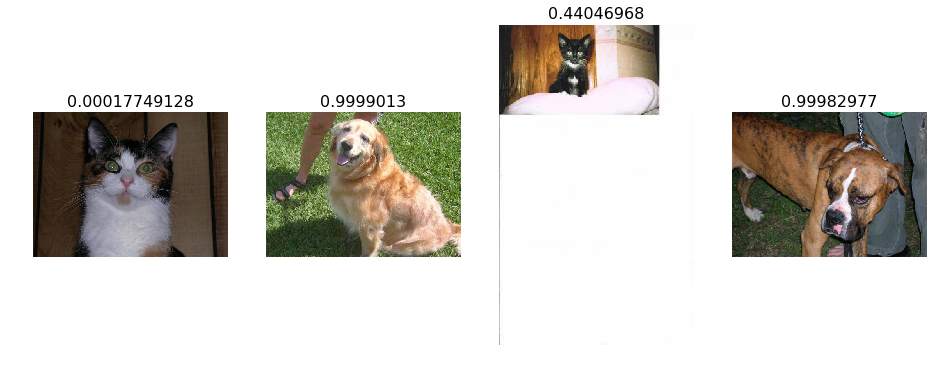

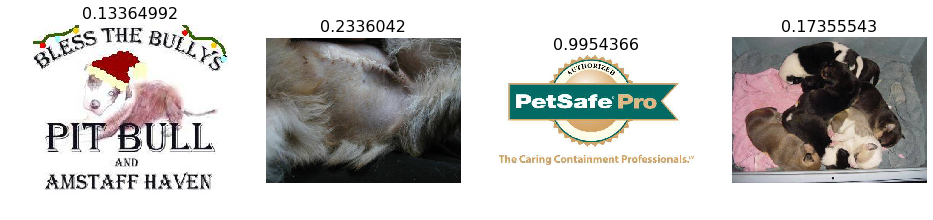

In [21]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(True), "Correctly classified")

# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [22]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


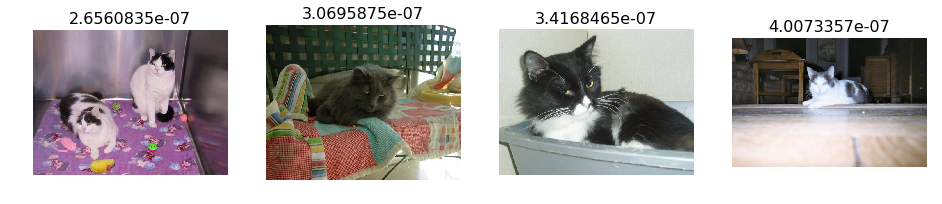

In [23]:
# Most correct cats
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


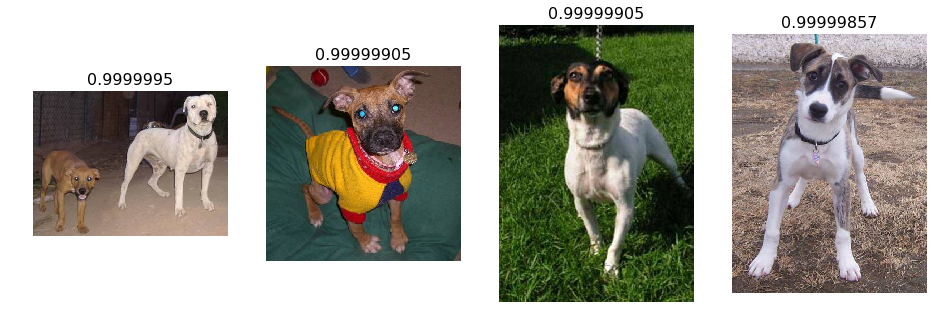

In [24]:
# Most correct dogs
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


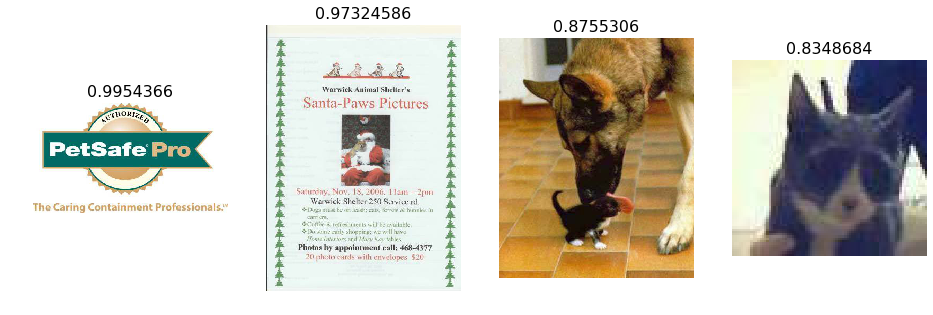

In [25]:
# Most incorrect cats
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


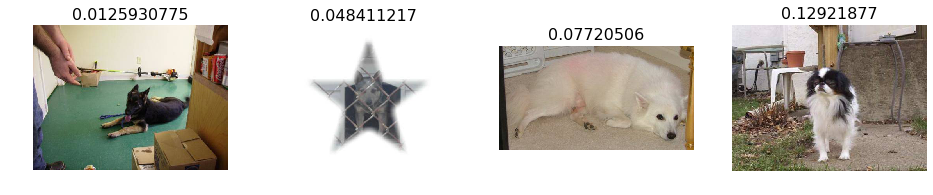

In [26]:
# Most incorrect dogs
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


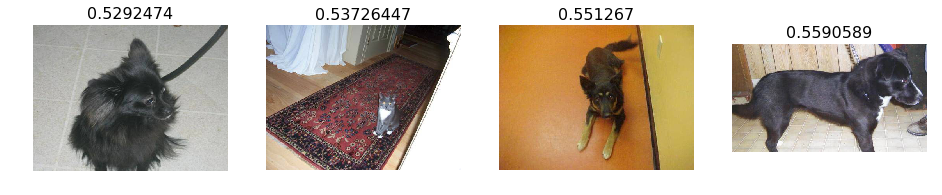

In [27]:
#Most uncertain predictions
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing learning Rate

In [28]:
# Create new learner to set learning rate for new untrained model
learn = ConvLearner.pretrained(arch, data, precompute=True)

# find an optimal learning rate find an optimal learning rate. 
# we simply keep increasing the learning rate from a very small value, until the loss stops decreasing
# we should re run this command as model changes
learn.lr_find()

 78%|███████▊  | 282/360 [00:04<00:01, 44.71it/s, loss=0.16] 


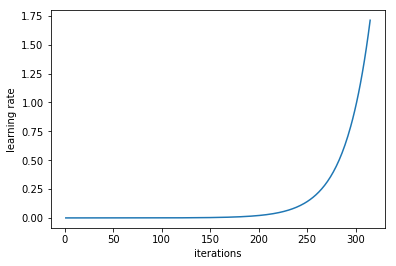

In [29]:
# for mini batch we increate the learning rate , the losses will decrease & then get worse
learn.sched.plot_lr()

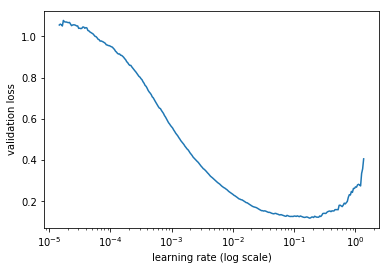

In [30]:
# plot of loss vs learning rate
learn.sched.plot()

# Imroving our model using Data augmentation

In [31]:
# Defining Data augmentation transformations
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [32]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])

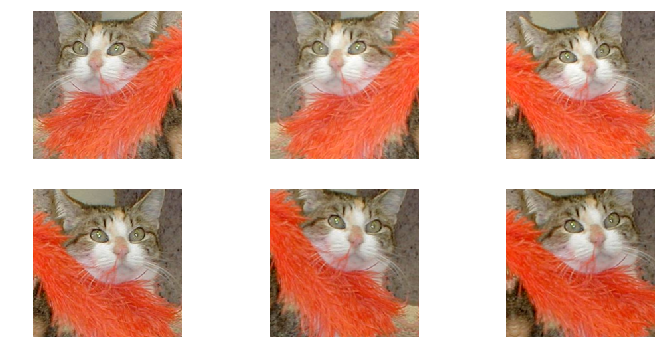

In [33]:
# visualise transformations
plots(ims, rows=2)

In [34]:
# new data object that includes this augmentation in the transforms.
# allows the convolutional neural net to learn how to recognize cats or dogs from  different angles.
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

# Initially, the augmentations actually do nothing because of precompute=True
learn = ConvLearner.pretrained(arch, data, precompute=True)

learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048828   0.029881   0.99      



[array([0.02988]), 0.99]

In [35]:
# So far We are using a pre-trained network which has already learned to recognize features 
# (i.e. we do not want to change hyper parameters it learned), 
# so what we can do is to pre-compute activations for hidden layers and just train the final linear portion.
# To use data augmentation, we have to do learn.precompute=False
learn.precompute=False

In [36]:
# cycle_len enables stochastic gradient descent with restarts (SGDR). 
# small changes to the weights may result in big changes to the loss. 
# We want to encourage our model to find parts of the weight space that are both accurate and stable. 
# Therefore, from time to time we increase the learning rate (this is the ‘restarts’ in ‘SGDR’), 
# which will force the model to jump to a different part of the weight space if the current area is “spiky”
# The basic idea is as you get closer and closer to the spot with the minimal loss,
# you may want to start decrease the learning rate (taking smaller steps) in order to get to exactly the right spot.
# This is called learning rate learning rate annealing 
# An approach is simply to pick some kind of functional form 
# really good functional form is one half of the cosign curve 
# which maintains the high learning rate for a while at the beginning, then drop quickly when you get closer.
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.042048   0.02642    0.9925    
    1      0.04228    0.025396   0.992                        
    2      0.038569   0.023771   0.9905                       



[array([0.02377]), 0.9905]

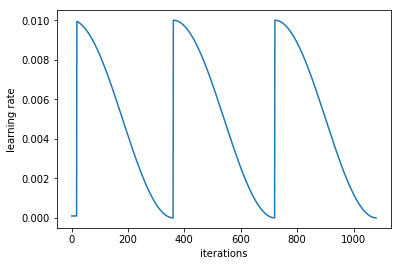

In [37]:
# Visualization of LR due to LR anealing and SDGR 
learn.sched.plot_lr()

In [38]:
# Save model
learn.save('224_lastlayer')

# Load saved model
learn.load('224_lastlayer')

# Fine-tuning and differential learning rate annealing

In [39]:
# So far, we have not retrained any of pre-trained features — 
# specifically, any of those weights in the convolutional kernels. 
# All we have done is we added some new layers on top and learned how to mix and match pre-trained features.

# Images like satellite images, CT scans, etc have totally different kinds of features all together 
# so you want to re-train many layers.
# For dogs and cats, images are similar to what the model was pre-trained with, 
# but we still may find it is helpful to slightly tune some of the later layers.
# Here is how you tell the learner that we want to start actually changing the convolutional filters themselves:

learn.unfreeze()

In [40]:
# Earlier layers like the first layer (which detects diagonal edges or gradient) or 
# the second layer (which recognizes corners or curves) probably do not need to change by much, if at all.
# Later layers are much more likely to need more learning. So we create an array of learning rates (differential learning rate)

lr=np.array([1e-4,1e-3,1e-2])

In [41]:
# Earlier we said 3 is the number of epochs, but it is actually cycles. 
#So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? 
#It is because of cycle_multcycle_mult=2 : this multiplies the length of the cycle after each cycle 
# (1 epoch + 2 epochs + 4 epochs = 7 epochs).
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.045694   0.025966   0.991     
    1      0.040596   0.019218   0.993                        
    2      0.035022   0.018968   0.9925                       
    3      0.027045   0.021262   0.992                        
    4      0.027029   0.018686   0.993                        
    5      0.022999   0.017357   0.993                        
    6      0.02003    0.017553   0.993                        



[array([0.01755]), 0.993]

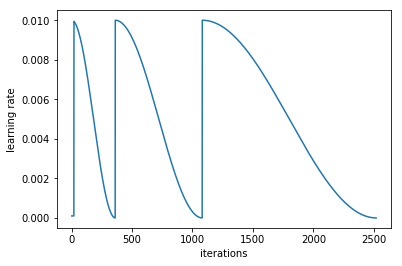

In [42]:
# Visualization of LR due to LR anealing and SDGR and differential learning rate
learn.sched.plot_lr()

In [43]:
# Save model
learn.save('224_lastlayer')

# Load saved model
learn.load('224_lastlayer')

## Test time Augmentation 

In [44]:
# Test Time Augmentation”. 
# we are going to take 4 data augmentations at random as well as the un-augmented original (center-cropped). 
# We will then calculate predictions for all these images, take the average, and make that our final prediction. 
# Note that this is only for validation set and/or test set.

log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [45]:
# Accuracy with Final model & TTA
accuracy_np(probs, y)

0.9935

# Analyzing Results

[[995   5]
 [  8 992]]


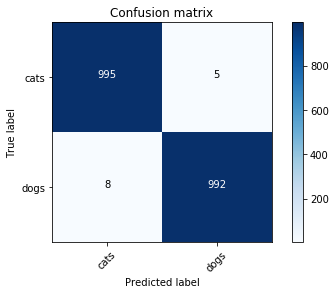

In [46]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

# Plotting confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

Most incorrect cats


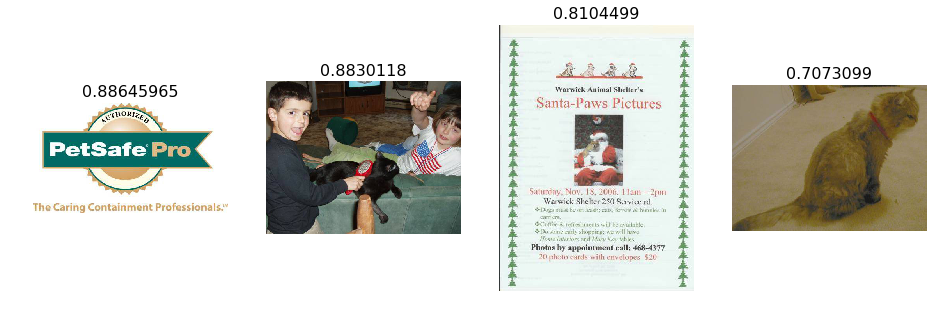

In [48]:
#Let’s look at the pictures again 

#Most incorrect cats 
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


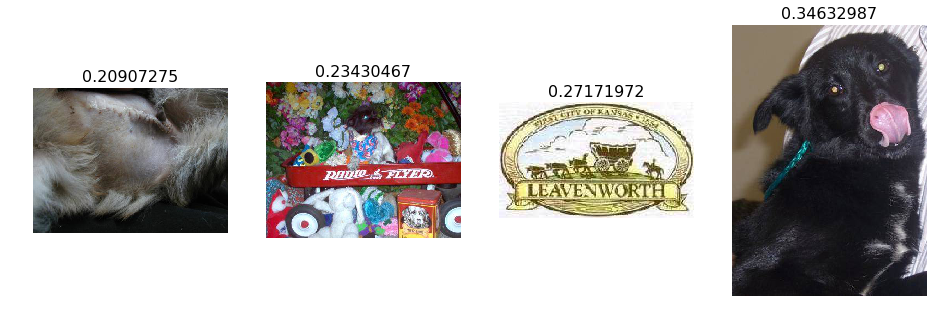

In [49]:
#Most incorrect dogs
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")